## Average CPU Cycles for Each Operation Bar chart
Load and preprocess the first 17 rows of benchmark CSV data, then plot a grouped bar chart (log scale) of average CPU cycles for each cryptographic operation.


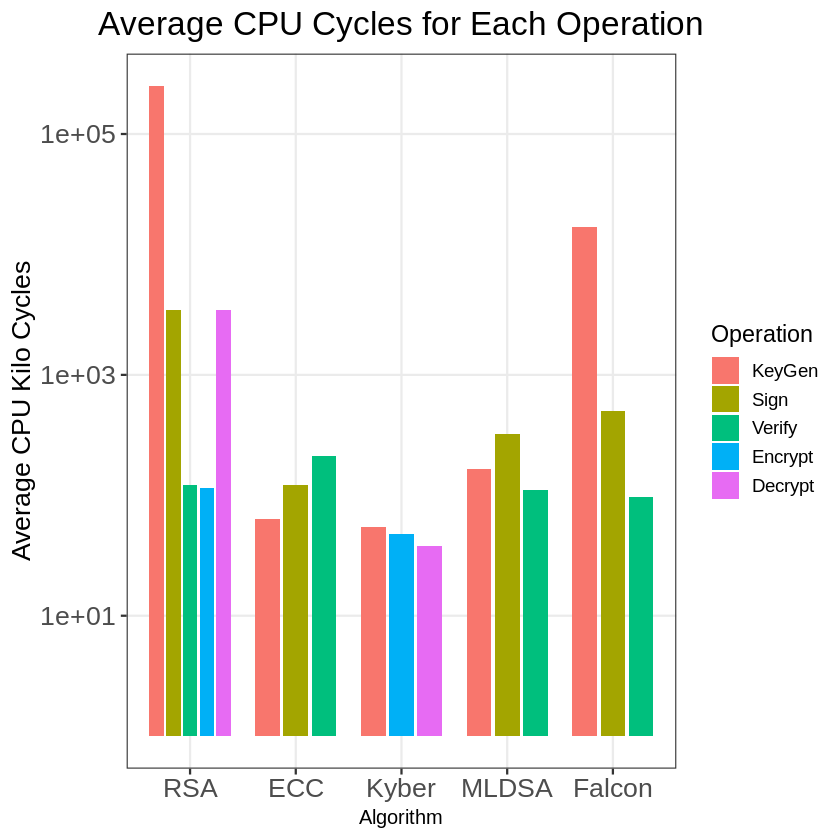

In [75]:
# Load necessary libraries
library(ggplot2)
library(scales)

# Read the first 17 rows of data from the CSV (excluding extra rows) and use only the Mean column
data <- read.csv("benchmark_data.csv", stringsAsFactors = FALSE, nrows = 17)

# Split Title into Benchmark and Operation
parts <- strsplit(data$Title, "_")
data$Benchmark <- sapply(parts, `[`, 1)
data$Operation <- sapply(parts, `[`, 2)

# Unify ECDHE and ECDSA into ECC
data$Benchmark[data$Benchmark %in% c("ECDHE", "ECDSA")] <- "ECC"

# Use the Mean column as AverageCycles
data$AverageCycles <- data$Mean

# Format Operation Name
data$Operation <- factor(data$Operation,
  levels = c("keygen", "sign", "verify", "encrypt", "decrypt"),
  labels = c("KeyGen",  "Sign",  "Verify",  "Encrypt",   "Decrypt")
)

# Define Benchmark order and convert to factors
data$Benchmark <- factor(data$Benchmark,
  levels = c("RSA", "ECC", "Kyber", "MLDSA", "Falcon")
)

# Draw a grouped bar chart (log10 magnitude)
p <- ggplot(data, aes(x = Benchmark, y = AverageCycles, fill = Operation)) +
  geom_col(position = position_dodge(width = 0.8), width = 0.7) +
  scale_y_log10() +
  labs(
    subtitle = "Average CPU Cycles for Each Operation",
    x        = "Algorithm",
    y        = "Average CPU Kilo Cycles",
    fill     = "Operation"
  ) +
  theme_bw(base_size = 14) +
  theme(
    plot.subtitle    = element_text(size = 20, hjust = 0.5),
    axis.text.x      = element_text(size = 16, hjust = 0.5),
    axis.text.y      = element_text(size = 16),
    axis.title.x     = element_text(size = 12),
    axis.title.y     = element_text(size = 16),
    legend.position  = "right",
    panel.grid.major = element_line(),
    panel.grid.minor = element_blank()
  )
# Save high resolution PNG
ggsave("cryptographic_time_comparison.png", p, width = 15, height = 10, dpi = 600)

# Display the graph
print(p)




## Cryptographic Parameters Comparison Bar chart

Read algorithm parameters from a JSON file, extract key security and size metrics, and create a faceted bar chart comparing these parameters across algorithms.


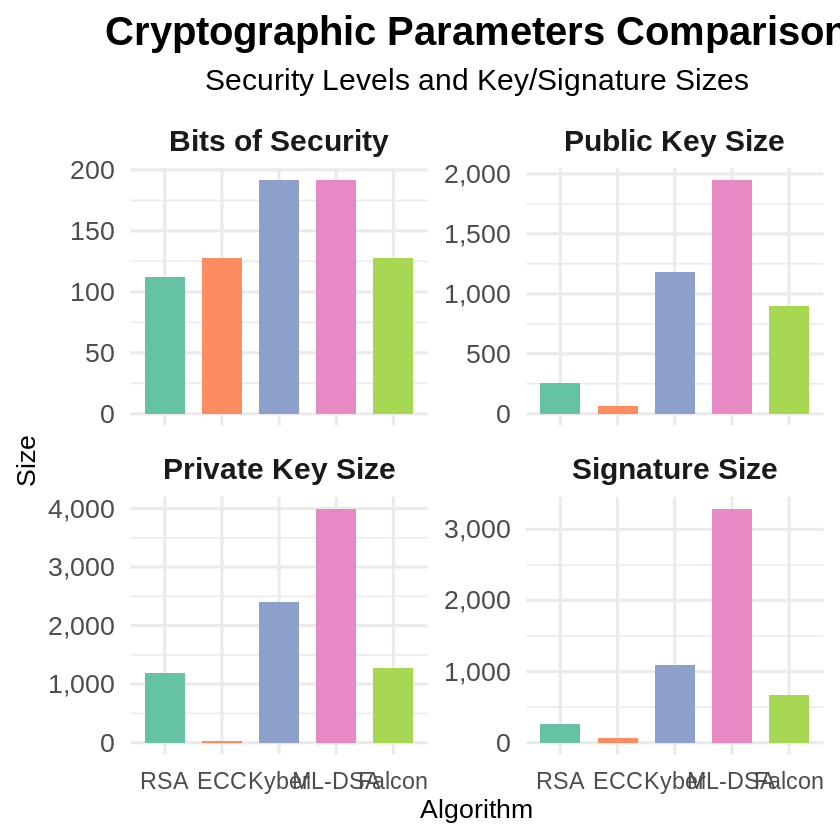

In [13]:
# Load necessary libraries
library(jsonlite)
library(ggplot2)
library(scales)

# Read algorithm parameters from a local JSON file
info <- fromJSON("algo_info.json")

# Extract only the "Single Algorithm" part
single <- info[["Single Algorithm"]]

# Defines the metric keys to be used and their mapping in the human-readable header
metric_keys <- c("bits_of_security", "public_key_size", "private_key_size", "signature_size")
metric_labels <- c(
  bits_of_security   = "Bits of Security",
  public_key_size    = "Public Key Size",
  private_key_size   = "Private Key Size",
  signature_size     = "Signature Size"
)

# Flatten a nested list into a data.frame
df_list <- lapply(names(single), function(algo_json) {
  vals <- single[[algo_json]][metric_keys]
  data.frame(
    Algorithm   = algo_json,
    MetricKey   = metric_keys,
    Value       = as.numeric(vals),
    stringsAsFactors = FALSE
  )
})
df <- do.call(rbind, df_list)

# Mapping algorithm names to short versions
df$Algorithm <- factor(df$Algorithm,
  levels = c("RSA 2048", "ECDSA secp256r1", "Kyber768", "ML-DSA (Dilithium3)", "Falcon-512"),
  labels = c("RSA",       "ECC",             "Kyber",    "ML-DSA",                  "Falcon")
)

# Convert MetricKey to human-readable label
df$Metric <- factor(metric_labels[df$MetricKey],
  levels = metric_labels
)

# Draw a bar graph
p <- ggplot(df, aes(x = Algorithm, y = Value, fill = Algorithm)) +
  geom_col(width = 0.7, show.legend = FALSE) +
  facet_wrap(~ Metric, scales = "free_y", ncol = 2) +
  scale_y_continuous(labels = comma) +
  scale_fill_brewer(palette = "Set2") +
  labs(
    title    = "Cryptographic Parameters Comparison",
    subtitle = "Security Levels and Key/Signature Sizes",
    x        = "Algorithm",
    y        = "Size"
  ) +
  theme_minimal(base_size = 20) +
  theme(
    plot.title    = element_text(face = "bold", size = 24, hjust = 0.5),
    plot.subtitle = element_text(size = 18, hjust = 0.5),
    axis.text.x   = element_text(angle = 0, hjust = 0.5, vjust = 0.5, size = 14),
    axis.title    = element_text(size = 16),
    strip.text    = element_text(face = "bold", size = 18)
  )

# Export high resolution images (in centimeters)
ggsave(
  filename = "algorithm_parameters_comparison.png",
  plot     = p,
  width    = 30, height = 24,
  units    = "cm",
  dpi      = 600
)

# Display graphics
print(p)


## TLS handshake benchmark comparison Bar chart

Extract “Total_time” entries from rows 18 onward, assign labels for each TLS variant, and plot a bar chart to compare handshake durations.


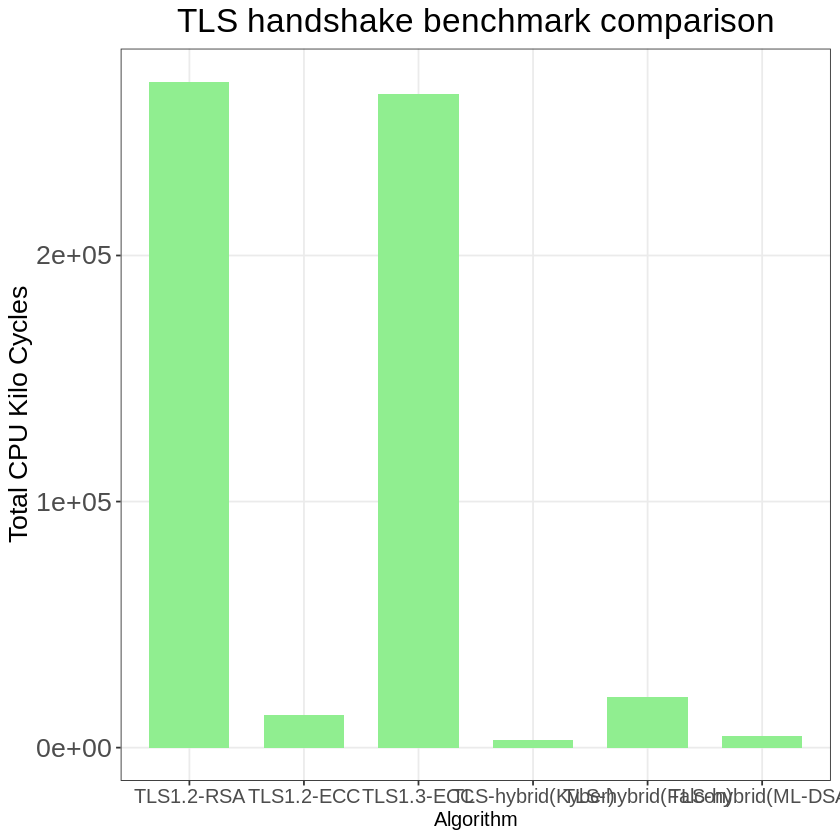

In [81]:
# Load the ggplot2 package
library(ggplot2)

# Read CSV file (adjust according to the actual path)
data <- read.csv("benchmark_data.csv", header = TRUE, stringsAsFactors = FALSE)

# Extract all data from row 18 onwards
df_all <- data[18:nrow(data), ]

# Filter out rows where Title is "Total_time"
df_tt <- df_all[df_all$Title == "Total_time", ]

# Define the corresponding algorithm name label
labels <- c(
  "TLS1.2-RSA",
  "TLS1.2-ECC",
  "TLS1.3-ECC",
  "TLS-hybrid(Kyber)",
  "TLS-hybrid(Falcon)",
  "TLS-hybrid(ML‑DSA)"
)

# Assign new labels to each Total_time row, keeping the order
df_tt$Label <- factor(labels, levels = labels)

# Build a bar chart: Use light green fill
p <- ggplot(df_tt, aes(x = Label, y = Mean)) +
  geom_bar(stat = "identity", width = 0.7, fill = "lightgreen") +
  labs(
    x = "Algorithm",
    y = "Total CPU Kilo Cycles",
    title = "TLS handshake benchmark comparison"
  ) +
  theme_bw() +
  theme(
    plot.title    = element_text(size = 20, hjust = 0.5),
    axis.text.x      = element_text(size = 12, hjust = 0.5),
    axis.text.y      = element_text(size = 16),
    axis.title.x     = element_text(size = 12),
    axis.title.y     = element_text(size = 16),
    panel.grid.major = element_line(),
    panel.grid.minor = element_blank()
  )


# Save the chart in PNG format
ggsave(
  filename = "tls_time_comparison.png",
  plot     = p,
  width    = 13,
  height   = 8,
  dpi      = 600
)

# Display graphics in the window
print(p)
